# Plots of the Appendix 

Note that the sliding window plots are in the relative notebook **sliding_window.ipynb** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from   matplotlib.colors import SymLogNorm
import matplotlib.gridspec as gridspec
import post_process
from post_process import POSTPROCESS
import pandas as pd
import os
import glob

In [2]:
hex6 = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000']
colors6=[mcolors.to_rgb(i) for i in hex6]

colors = ['white', colors6[2]]
positions = [0, 1]
cmap0 = mcolors.LinearSegmentedColormap.from_list("", list(zip(positions, colors)))
cb_palette = ['#648FFF', '#785EF0', '#DC267F', '#FE6100', '#FFB000', '#3CAB20', '#6B750C', '#A6761D', '#D8A21E', '#F0E442',
              '#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', '#8C564B', '#E377C2', '#7F7F7F', '#BCBD22', '#17BECF']

## Compute descriptors used in the paper

In [3]:
def inter_layer_persistance(model,num_layers,p=1):

    pds = post_process.read_pd_from_csv(model, max_dim = 5)
    pp = POSTPROCESS(pds = pds, num_layers = num_layers*2, start_ind = 1, zigzag = True, debug = False)
    psim = pp.find_ph_sim()[p]
    bettis = pp.find_betti_layers()[p]
    temp = np.zeros((num_layers,num_layers))
    for i in range(num_layers):
        if bettis[i] == 0:
            temp[i] = 0
        else:
            temp[i] = psim[i]/bettis[i]
    return temp

In [4]:
def weighed_inter_layer_persistance(layer_pers,n_layers,p=1):
    weights = np.zeros((n_layers,n_layers))
    for i in range(n_layers):
        for j in range(n_layers):
                if p < 0 and i == j:
                    weights[i][j] = 1e-10
                else:
                    weights[i][j] = np.abs(i-j)**p
    return np.sum(layer_pers*weights,axis=1)/np.sum(weights,axis=1)


In [5]:
def pi_hist(model,num_layers,p=2,axis=1):
    weights = np.zeros((num_layers,num_layers))
    for i in range(num_layers):
        for j in range(num_layers):
                if p < 0 and i == j:
                    weights[i][j] = 1e-10
                else:
                    weights[i][j] = np.abs(i-j)**p
    pis = effective_pi(model,num_layers)
    pis_hist = np.sum(pis*weights,axis=axis)/np.sum(weights,axis=axis)
    # Normalize pis_hist to 1
    pis_hist /= np.sum(pis_hist)
    return pis_hist

In [6]:
def effective_pi(model,num_layers,p=1):
    pds = post_process.read_pd_from_csv(model, max_dim = 5)
    pp = POSTPROCESS(pds = pds, num_layers = num_layers*2, start_ind = 1, zigzag = True, debug = False)
    pis = pp.find_eff_pis()[p]
    pis_pers = np.zeros((num_layers,num_layers))
    pis_death = np.zeros((num_layers,num_layers))
    for i in range(num_layers):
        for j in range(num_layers):
            if i-j>=0:
                pis_pers[i-j,j] = pis[i,j]
            pis_death[i,j] = pis[i,j]
    return pis_death

# Figure 5

In [7]:
models= [["./csv/sst/llama_3_8b_dim_4_knn_5_last_token.csv",'$k_{\\rm NN} (\\bar{\\mathcal{Z}}_1)$'],
        ["./csv/vietoris/llama3_8_vietoris_MIN_knn_5_cluster_500_dim_4.csv",'$k_{\\rm NN}$-VR $(\\bar{\\mathcal{Z}}_0)$'],
        ["./csv/vietoris/llama3_8_vietoris_MIN_knn_5_cluster_500_dim_4.csv",'$k_{\\rm NN}$-VR $(\\bar{\\mathcal{Z}}_1)$']]
num_layers = 33

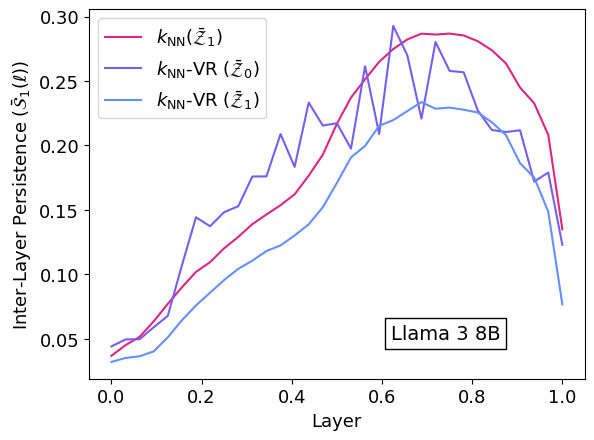

In [8]:

x = np.linspace(0, 1, num_layers)
    

temp = inter_layer_persistance(models[0][0],num_layers)
r = weighed_inter_layer_persistance(temp,num_layers,p=0)
plt.plot(x,r,label=models[0][1],color=hex6[2])

temp = inter_layer_persistance(models[1][0],num_layers,p=0)
r = weighed_inter_layer_persistance(temp,num_layers,p=0)
plt.plot(x,r,label=models[1][1],color=hex6[1])

temp = inter_layer_persistance(models[2][0],num_layers)
r = weighed_inter_layer_persistance(temp,num_layers,p=0)
plt.plot(x,r,label=models[2][1],color=hex6[0])

plt.legend()
plt.text(0.62, 0.05, 'Llama 3 8B', fontsize=14,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))
plt.xlabel("Layer",fontsize=13)
plt.ylabel("Inter-Layer Persistence ($\\bar{\\mathcal{S}}_1(\\ell)$)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

# Figure 6

In [9]:
import seaborn as sns

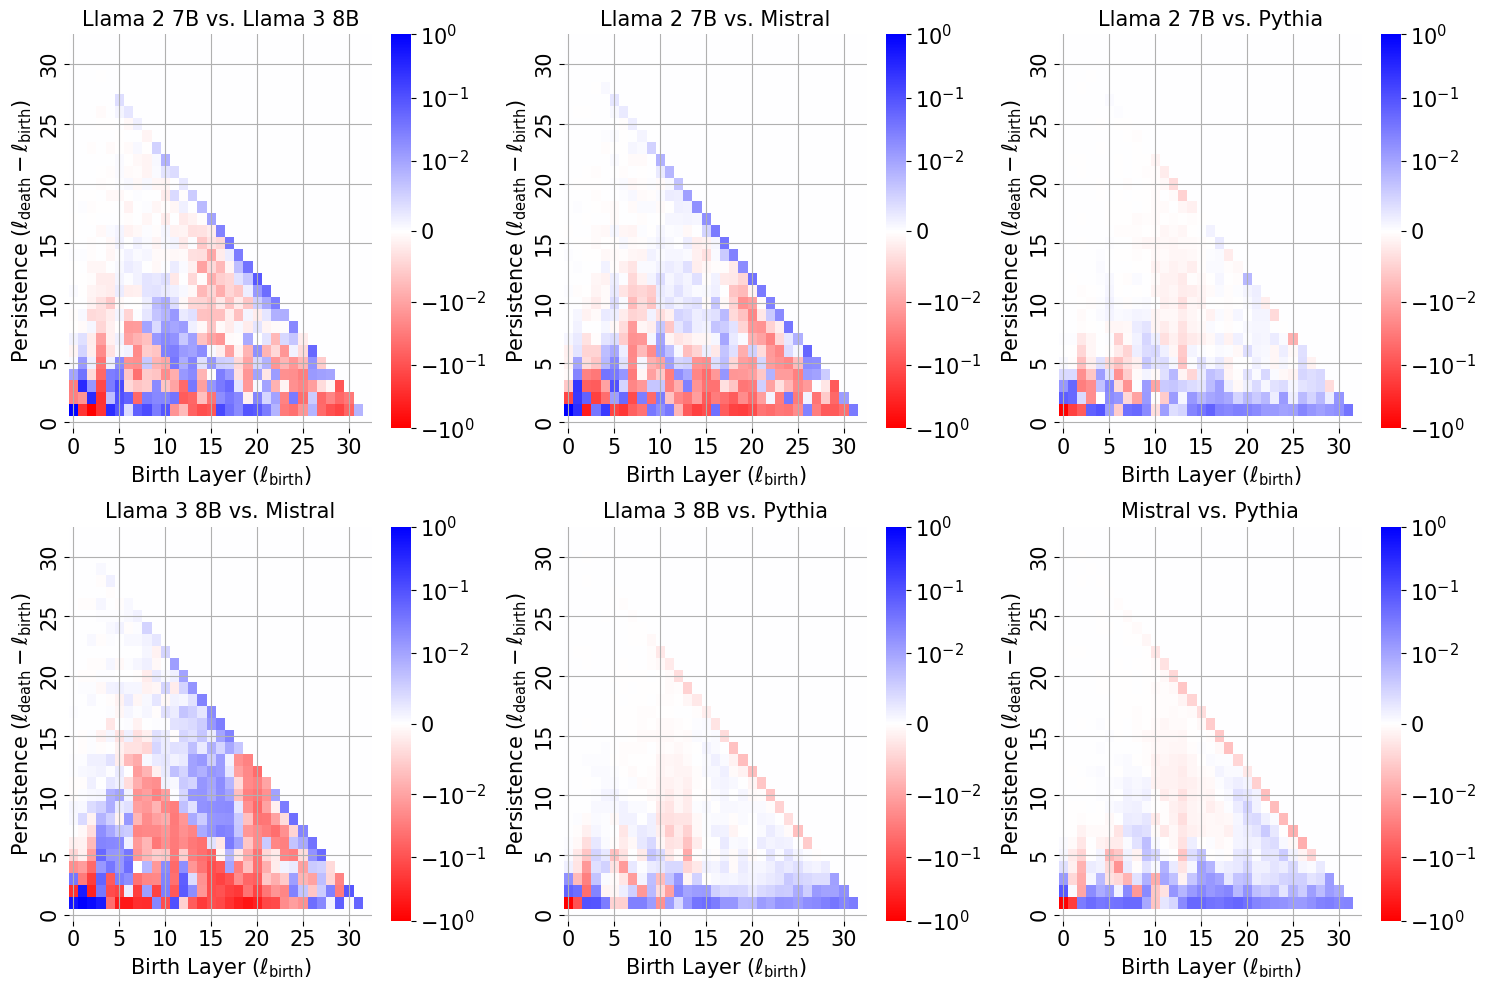

In [10]:
models_list = ["./csv/sst/llama_2_7b_dim_4_knn_5_last_token.csv",\
                "./csv/sst/llama_3_8b_dim_4_knn_5_last_token.csv",\
                "./csv/sst/mistral_sst_knn_5_dim_4.csv",\
                "./csv/sst/pythia6_9_deduped_knn_5_dim_4.csv"]
pis = []

for model in models_list:
    pds = post_process.read_pd_from_csv(model, max_dim = 5)
    pp = POSTPROCESS(pds = pds, num_layers = num_layers*2, start_ind = 1, zigzag = True, debug = False)
    pis.append(pp.find_eff_pis()[1])
pis_pers = []

for i in range(len(pis)):
    pis_pers.append(np.zeros((num_layers,num_layers)))
for k in range(len(pis)):
    for i in range(num_layers):
        for j in range(num_layers):
            if i-j>=0:
                pis_pers[k][i-j,j] = pis[k][i,j]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

def normalize_diff(a, b):
    diff = a - b
    return diff/np.max(np.abs(diff))

sns.heatmap(normalize_diff(pis_pers[0], pis_pers[1]), ax=axes[0,0], xticklabels=5, yticklabels=5, norm=SymLogNorm(linthresh=0.01, linscale=1,
                                           vmin=-1., vmax=1.), cmap='bwr_r')
axes[0,0].set_title('Llama 2 7B vs. Llama 3 8B', fontsize=15)

sns.heatmap(normalize_diff(pis_pers[0], pis_pers[2]), ax=axes[0,1], xticklabels=5, yticklabels=5, norm=SymLogNorm(linthresh=0.01, linscale=1,
                                           vmin=-1., vmax=1.), cmap='bwr_r')
axes[0,1].set_title('Llama 2 7B vs. Mistral', fontsize=15)

sns.heatmap(normalize_diff(pis_pers[0], pis_pers[3]), ax=axes[0,2], xticklabels=5, yticklabels=5, norm=SymLogNorm(linthresh=0.01, linscale=1,
                                           vmin=-1., vmax=1.), cmap='bwr_r')
axes[0,2].set_title('Llama 2 7B vs. Pythia', fontsize=15)

sns.heatmap(normalize_diff(pis_pers[1], pis_pers[2]), ax=axes[1,0], xticklabels=5, yticklabels=5, norm=SymLogNorm(linthresh=0.01, linscale=1,
                                           vmin=-1., vmax=1.), cmap='bwr_r')
axes[1,0].set_title('Llama 3 8B vs. Mistral', fontsize=15)

sns.heatmap(normalize_diff(pis_pers[1], pis_pers[3]), ax=axes[1,1], xticklabels=5, yticklabels=5, norm=SymLogNorm(linthresh=0.01, linscale=1,
                                           vmin=-1., vmax=1.), cmap='bwr_r')
axes[1,1].set_title('Llama 3 8B vs. Pythia', fontsize=15)

sns.heatmap(normalize_diff(pis_pers[2], pis_pers[3]), ax=axes[1,2], xticklabels=5, yticklabels=5, norm=SymLogNorm(linthresh=0.01, linscale=1,
                                           vmin=-1., vmax=1.), cmap='bwr_r')
axes[1,2].set_title('Mistral vs. Pythia', fontsize=15)

for i in range(2):
    for j in range(3):
        axes[i,j].tick_params(axis='both', which='major', labelsize=15)
        axes[i,j].invert_yaxis()
        axes[i,j].set_xlabel('Birth Layer $(\\ell_{\\rm birth})$', fontsize=15)
        axes[i,j].set_ylabel('Persistence $(\\ell_{\\rm death}-\\ell_{\\rm birth})$', fontsize=15)
        axes[i,j].grid(True)
        cbar = axes[i,j].collections[0].colorbar
        cbar.ax.tick_params(labelsize=15)

plt.tight_layout()
plt.show()

# Figure 7

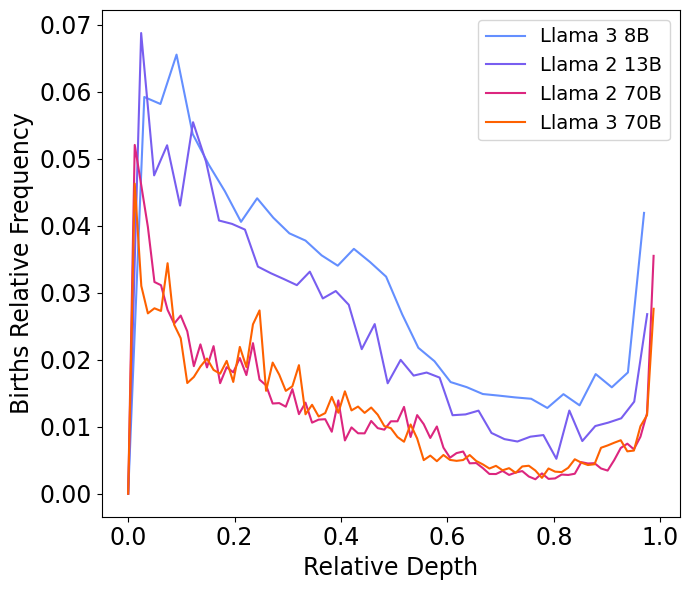

In [11]:
p = 0

llama2_13b = './csv/sst/llama_2_13b_dim_4_knn_4_last_token.csv'
llama2_70b = './csv/sst/llama_2_70b_dim_4_knn_4_last_token.csv'
llama3_8b = './csv/sst/llama_3_8b_dim_4_knn_4_last_token.csv'
llama_3_70b = './csv/sst/llama_3_70b_dim_4_knn_4_last_token.csv'

pi_hist_llama2_13b = pi_hist(llama2_13b, 41,p)
pi_hist_llama2_70b = pi_hist(llama2_70b, 81,p)
pi_hist_llama3_70b = pi_hist(llama_3_70b, 81,p)
pi_hist_llama3_8b = pi_hist(llama3_8b, 33,p)

x33 = np.arange(33)/33
x41 = np.arange(41)/41
x81 = np.arange(81)/81

plt.figure(figsize=(7, 6))
plt.plot(x33, pi_hist_llama3_8b, color=cb_palette[0], label='Llama 3 8B')
plt.plot(x41, pi_hist_llama2_13b, color=cb_palette[1], label='Llama 2 13B')
plt.plot(x81, pi_hist_llama2_70b, color=cb_palette[2], label='Llama 2 70B')
plt.plot(x81, pi_hist_llama3_70b, color=cb_palette[3], label='Llama 3 70B')
plt.tick_params(axis='both', which='major', labelsize=17)
plt.xlabel('Relative Depth', fontsize=17)
plt.ylabel('Births Relative Frequency', fontsize=17)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


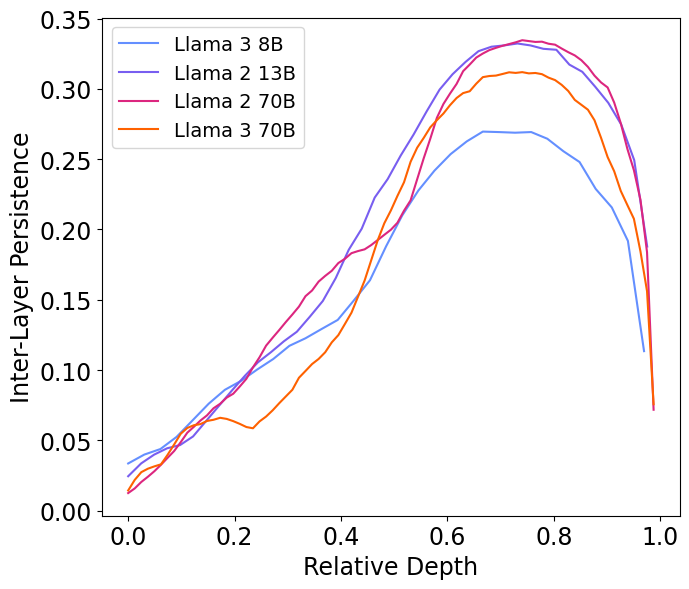

In [12]:
p = 0

pi_hist_llama2_13b = weighed_inter_layer_persistance(inter_layer_persistance(llama2_13b, 41),41,p)
pi_hist_llama2_70b = weighed_inter_layer_persistance(inter_layer_persistance(llama2_70b, 81),81,p)
pi_hist_llama3_70b = weighed_inter_layer_persistance(inter_layer_persistance(llama_3_70b, 81),81,p)
pi_hist_llama3_8b =  weighed_inter_layer_persistance(inter_layer_persistance(llama3_8b, 33),33,p)

x33 = np.arange(33)/33
x41 = np.arange(41)/41
x81 = np.arange(81)/81

plt.figure(figsize=(7, 6))
plt.plot(x33, pi_hist_llama3_8b, color=cb_palette[0], label='Llama 3 8B')
plt.plot(x41, pi_hist_llama2_13b, color=cb_palette[1], label='Llama 2 13B')
plt.plot(x81, pi_hist_llama2_70b, color=cb_palette[2], label='Llama 2 70B')
plt.plot(x81, pi_hist_llama3_70b, color=cb_palette[3], label='Llama 3 70B')
plt.tick_params(axis='both', which='major', labelsize=17)
plt.xlabel('Relative Depth', fontsize=17)
plt.ylabel('Inter-Layer Persistence', fontsize=17)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Figure 8

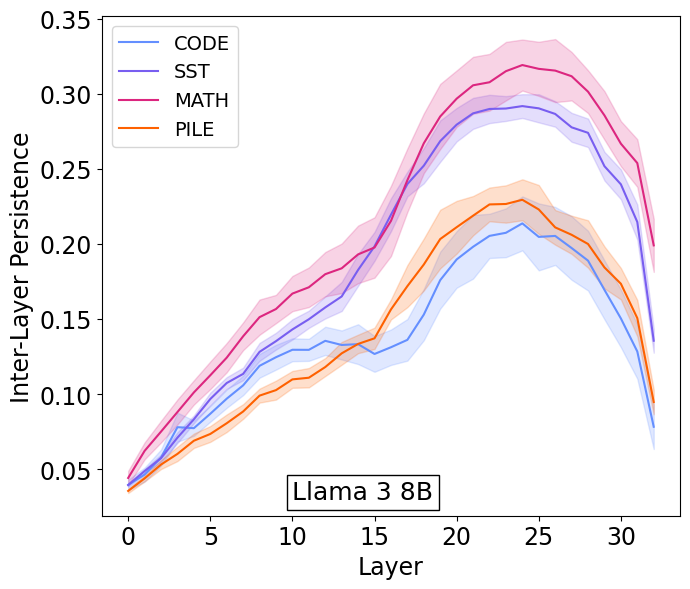

In [13]:
split_500_llama3b_code = glob.glob('./csv/split_code/llama3-8b/knn4/16_split/*')
split_500_llama3b_math = glob.glob('./csv/split_math/llama3-8b/knn4/16_split/*')
split_500_llama3b_pile = glob.glob('./csv/split_pile/llama3-8b/knn4/16_split/*')
split_500_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/16_split/*')

avgsim_llama3_code = []
avgsim_llama3_math = []
avgsim_llama3_sst = []
avgsim_llama3_pile = []
num_layers = 33


for model in split_500_llama3b_code:
    avgsim_llama3_code.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))

for model in split_500_llama3b_math:
    avgsim_llama3_math.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))

for model in split_500_llama3b:
    avgsim_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))

for model in split_500_llama3b_pile:
    avgsim_llama3_pile.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))

avgsim_llama3_code_mean = np.mean(avgsim_llama3_code, axis=0)
avgsim_llama3_code_std = np.std(avgsim_llama3_code, axis=0)

avgsim_llama3_math_mean = np.mean(avgsim_llama3_math, axis=0)
avgsim_llama3_math_std = np.std(avgsim_llama3_math, axis=0)

avgsim_llama3_mean = np.mean(avgsim_llama3_sst, axis=0)
avgsim_llama3_std = np.std(avgsim_llama3_sst, axis=0)

avgsim_llama3_pile_mean = np.mean(avgsim_llama3_pile, axis=0)
avgsim_llama3_pile_std = np.std(avgsim_llama3_pile, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
x = np.arange(num_layers)
ax.plot(x, avgsim_llama3_code_mean, color=cb_palette[0], label='CODE')
ax.fill_between(x, avgsim_llama3_code_mean - avgsim_llama3_code_std, avgsim_llama3_code_mean + avgsim_llama3_code_std, color=cb_palette[0], alpha=0.2)
ax.plot(x, avgsim_llama3_mean, color=cb_palette[1], label='SST')
ax.fill_between(x, avgsim_llama3_mean - avgsim_llama3_std, avgsim_llama3_mean + avgsim_llama3_std, color=cb_palette[1], alpha=0.2)
ax.plot(x, avgsim_llama3_math_mean, color=cb_palette[2], label='MATH')
ax.fill_between(x, avgsim_llama3_math_mean - avgsim_llama3_math_std, avgsim_llama3_math_mean + avgsim_llama3_math_std, color=cb_palette[2], alpha=0.2)
ax.plot(x, avgsim_llama3_pile_mean, color=cb_palette[3], label='PILE')
ax.fill_between(x, avgsim_llama3_pile_mean - avgsim_llama3_pile_std, avgsim_llama3_pile_mean + avgsim_llama3_pile_std, color=cb_palette[3], alpha=0.2)
ax.set_xticks(np.arange(0, num_layers, 5))
ax.tick_params(axis='both', which='major', labelsize=17)
ax.text(10, 0.03, 'Llama 3 8B', bbox=dict(facecolor='white', alpha=1.0), fontsize=18)
ax.set_xlabel('Layer', fontsize=17)
ax.set_ylabel('Inter-Layer Persistence', fontsize=17)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()



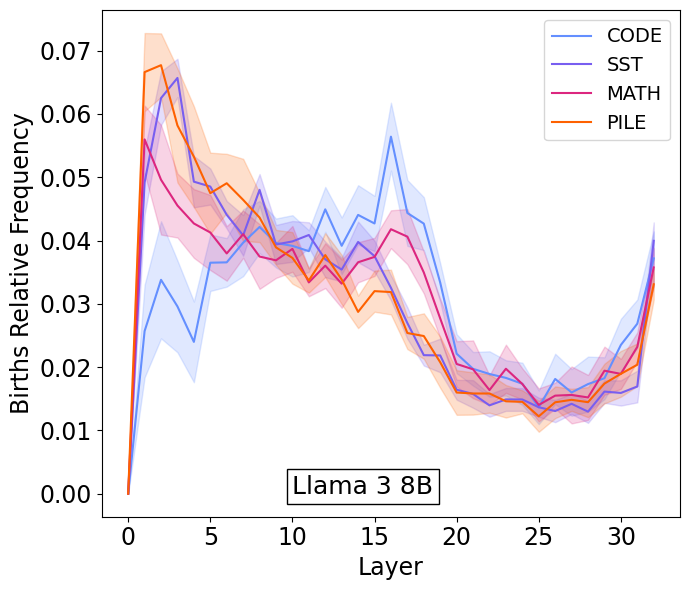

In [14]:
avgsim_llama3_code = []
avgsim_llama3_math = []
avgsim_llama3_sst = []
avgsim_llama3_pile = []
num_layers = 33

for model in split_500_llama3b_code:
    avgsim_llama3_code.append(pi_hist(model, num_layers,p))

for model in split_500_llama3b_math:
    avgsim_llama3_math.append(pi_hist(model, num_layers,p))

for model in split_500_llama3b:
    avgsim_llama3_sst.append(pi_hist(model, num_layers,p))

for model in split_500_llama3b_pile:
    avgsim_llama3_pile.append(pi_hist(model, num_layers,p))

avgsim_llama3_code_mean = np.mean(avgsim_llama3_code, axis=0)
avgsim_llama3_code_std = np.std(avgsim_llama3_code, axis=0)

avgsim_llama3_math_mean = np.mean(avgsim_llama3_math, axis=0)
avgsim_llama3_math_std = np.std(avgsim_llama3_math, axis=0)

avgsim_llama3_mean = np.mean(avgsim_llama3_sst, axis=0)
avgsim_llama3_std = np.std(avgsim_llama3_sst, axis=0)

avgsim_llama3_pile_mean = np.mean(avgsim_llama3_pile, axis=0)
avgsim_llama3_pile_std = np.std(avgsim_llama3_pile, axis=0)


fig, ax = plt.subplots(1, 1, figsize=(7, 6))
x = np.arange(num_layers)
ax.plot(x, avgsim_llama3_code_mean, color=cb_palette[0], label='CODE')
ax.fill_between(x, avgsim_llama3_code_mean - avgsim_llama3_code_std, avgsim_llama3_code_mean + avgsim_llama3_code_std, color=cb_palette[0], alpha=0.2)
ax.plot(x, avgsim_llama3_mean, color=cb_palette[1], label='SST')
ax.fill_between(x, avgsim_llama3_mean - avgsim_llama3_std, avgsim_llama3_mean + avgsim_llama3_std, color=cb_palette[1], alpha=0.2)
ax.plot(x, avgsim_llama3_math_mean, color=cb_palette[2], label='MATH')
ax.fill_between(x, avgsim_llama3_math_mean - avgsim_llama3_math_std, avgsim_llama3_math_mean + avgsim_llama3_math_std, color=cb_palette[2], alpha=0.2)
ax.plot(x, avgsim_llama3_pile_mean, color=cb_palette[3], label='PILE')
ax.fill_between(x, avgsim_llama3_pile_mean - avgsim_llama3_pile_std, avgsim_llama3_pile_mean + avgsim_llama3_pile_std, color=cb_palette[3], alpha=0.2)
ax.set_xticks(np.arange(0, num_layers, 5))
ax.text(10, 0, 'Llama 3 8B' , bbox=dict(facecolor='white', alpha=1.0), fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_xlabel('Layer', fontsize=17)
ax.set_ylabel('Births Relative Frequency', fontsize=17)
ax.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Figure 9

In [15]:
c_list = ["./csv/lang_split/llama3-8b/llama-3-8b_C_split_0_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_C_split_1_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_C_split_2_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_C_split_3_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_C_split_4_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_C_split_5_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_C_split_6_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_C_split_7_dim_4.csv"]
html_list = ["./csv/lang_split/llama3-8b/llama-3-8b_HTML_split_0_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_HTML_split_1_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_HTML_split_2_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_HTML_split_3_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_HTML_split_4_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_HTML_split_5_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_HTML_split_6_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_HTML_split_7_dim_4.csv"]

java_list = ["./csv/lang_split/llama3-8b/llama-3-8b_Java_split_0_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Java_split_1_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Java_split_2_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Java_split_3_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Java_split_4_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Java_split_5_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Java_split_6_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Java_split_7_dim_4.csv"]

markdown_list = ["./csv/lang_split/llama3-8b/llama-3-8b_Markdown_split_0_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Markdown_split_1_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Markdown_split_2_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Markdown_split_3_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Markdown_split_4_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Markdown_split_5_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Markdown_split_6_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Markdown_split_7_dim_4.csv"]

python_list = ["./csv/lang_split/llama3-8b/llama-3-8b_Python_split_0_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Python_split_1_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Python_split_2_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Python_split_3_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Python_split_4_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Python_split_5_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Python_split_6_dim_4.csv",\
                "./csv/lang_split/llama3-8b/llama-3-8b_Python_split_7_dim_4.csv"]

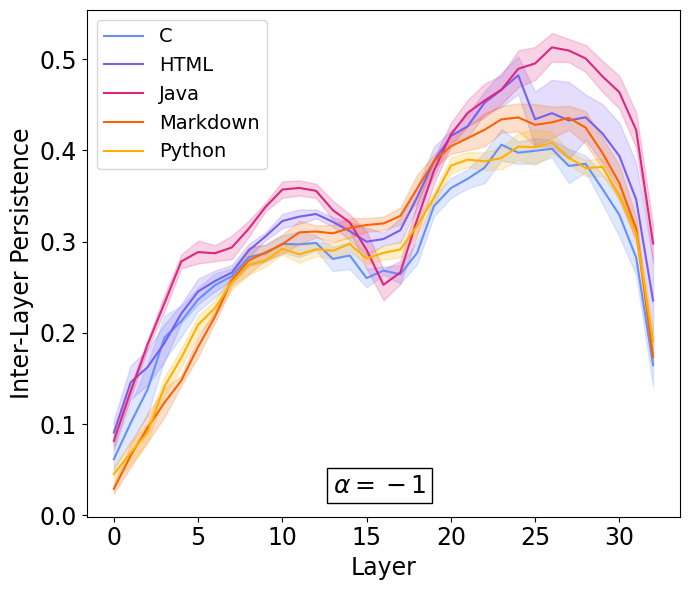

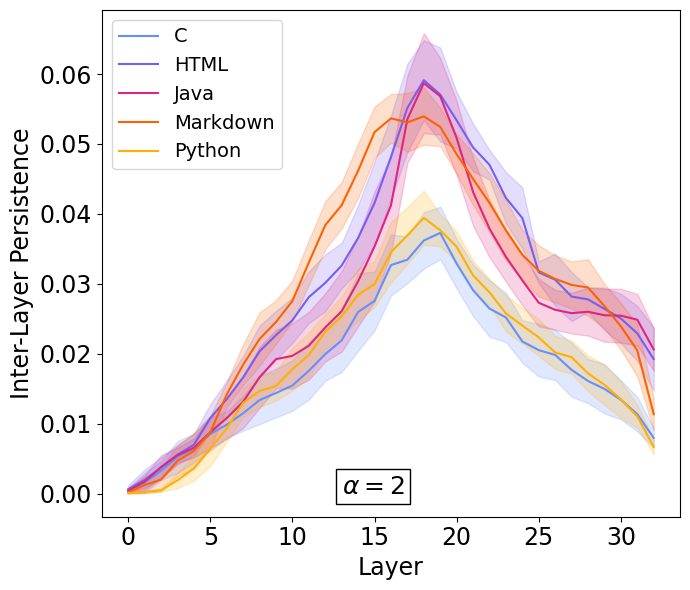

In [16]:
for p in [-1.,2]:
    avgsim_llama3_c = []
    avgsim_llama3_html = []
    avgsim_llama3_java = []
    avgsim_llama3_markdown = []
    avgsim_llama3_python = []

    for model in c_list:
        avgsim_llama3_c.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
    for model in html_list:
        avgsim_llama3_html.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
    for model in java_list:
        avgsim_llama3_java.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
    for model in markdown_list:
        avgsim_llama3_markdown.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
    for model in python_list:
        avgsim_llama3_python.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))

    avgsim_llama3_c_mean = np.mean(avgsim_llama3_c, axis=0)
    avgsim_llama3_c_std = np.std(avgsim_llama3_c, axis=0)

    avgsim_llama3_html_mean = np.mean(avgsim_llama3_html, axis=0)
    avgsim_llama3_html_std = np.std(avgsim_llama3_html, axis=0)

    avgsim_llama3_java_mean = np.mean(avgsim_llama3_java, axis=0)
    avgsim_llama3_java_std = np.std(avgsim_llama3_java, axis=0)

    avgsim_llama3_markdown_mean = np.mean(avgsim_llama3_markdown, axis=0)
    avgsim_llama3_markdown_std = np.std(avgsim_llama3_markdown, axis=0)

    avgsim_llama3_python_mean = np.mean(avgsim_llama3_python, axis=0)
    avgsim_llama3_python_std = np.std(avgsim_llama3_python, axis=0)

    plt.figure(figsize=(7, 6))
    x = np.arange(num_layers)
    plt.plot(x, avgsim_llama3_c_mean, color=cb_palette[0], label='C')
    plt.fill_between(x, avgsim_llama3_c_mean - avgsim_llama3_c_std, avgsim_llama3_c_mean + avgsim_llama3_c_std, color=cb_palette[0], alpha=0.2)
    plt.plot(x, avgsim_llama3_html_mean, color=cb_palette[1], label='HTML')
    plt.fill_between(x, avgsim_llama3_html_mean - avgsim_llama3_html_std, avgsim_llama3_html_mean + avgsim_llama3_html_std, color=cb_palette[1], alpha=0.2)
    plt.plot(x, avgsim_llama3_java_mean, color=cb_palette[2], label='Java')
    plt.fill_between(x, avgsim_llama3_java_mean - avgsim_llama3_java_std, avgsim_llama3_java_mean + avgsim_llama3_java_std, color=cb_palette[2], alpha=0.2)
    plt.plot(x, avgsim_llama3_markdown_mean, color=cb_palette[3], label='Markdown')
    plt.fill_between(x, avgsim_llama3_markdown_mean - avgsim_llama3_markdown_std, avgsim_llama3_markdown_mean + avgsim_llama3_markdown_std, color=cb_palette[3], alpha=0.2)
    plt.plot(x, avgsim_llama3_python_mean, color=cb_palette[4], label='Python')
    plt.fill_between(x, avgsim_llama3_python_mean - avgsim_llama3_python_std, avgsim_llama3_python_mean + avgsim_llama3_python_std, color=cb_palette[4], alpha=0.2)


    plt.xticks(np.arange(0, num_layers, 5))
    plt.tick_params(axis='both', which='major', labelsize=17)
    if p == -1:           
        plt.text(13, 0.025, '$\\alpha = %d$'%p, bbox=dict(facecolor='white', alpha=1.0), fontsize=18)
    else:
        plt.text(13, 0.0, '$\\alpha = %d$'%p, bbox=dict(facecolor='white', alpha=1.0), fontsize=18)  
    plt.xlabel('Layer', fontsize=17)
    plt.ylabel('Inter-Layer Persistence', fontsize=17)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

# Figure 10

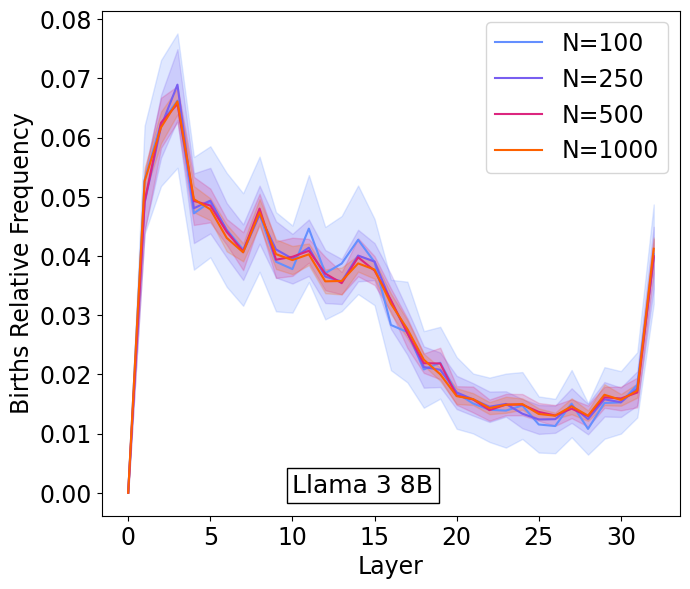

In [17]:
p=0
split_100_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/80_split/*')
split_125_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/64_split/*')
split_160_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/50_split/*')
split_200_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/40_split/*')
split_250_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/32_split/*')
split_320_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/25_split/*')
split_400_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/20_split/*')
split_500_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/16_split/*')
split_640_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/12_split/*')
split_800_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/10_split/*')
split_1000_llama3b = glob.glob('./csv/split_sst/llama3-8b/knn4/8_split/*')


edf_100_llama3 = []
edf_250_llama3 = []
edf_500_llama3 = []
edf_1000_llama3 = []

for model in split_100_llama3b:
    edf_100_llama3.append(pi_hist(model, num_layers,p))
for model in split_250_llama3b:
    edf_250_llama3.append(pi_hist(model, num_layers,p))
for model in split_500_llama3b:
    edf_500_llama3.append(pi_hist(model, num_layers,p))
for model in split_1000_llama3b:
    edf_1000_llama3.append(pi_hist(model, num_layers,p))

edf_100_llama3_mean = np.mean(edf_100_llama3, axis=0)
edf_100_llama3_std = np.std(edf_100_llama3, axis=0)
edf_250_llama3_mean = np.mean(edf_250_llama3, axis=0)
edf_250_llama3_std = np.std(edf_250_llama3, axis=0)
edf_500_llama3_mean = np.mean(edf_500_llama3, axis=0)
edf_500_llama3_std = np.std(edf_500_llama3, axis=0)
edf_1000_llama3_mean = np.mean(edf_1000_llama3, axis=0)
edf_1000_llama3_std = np.std(edf_1000_llama3, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
x = np.arange(num_layers)
ax.plot(x, edf_100_llama3_mean, color=cb_palette[0], label='N=100')
ax.fill_between(x, edf_100_llama3_mean - edf_100_llama3_std, edf_100_llama3_mean + edf_100_llama3_std, color=cb_palette[0], alpha=0.2)
ax.plot(x, edf_250_llama3_mean, color=cb_palette[1], label='N=250')
ax.fill_between(x, edf_250_llama3_mean - edf_250_llama3_std, edf_250_llama3_mean + edf_250_llama3_std, color=cb_palette[1], alpha=0.2)
ax.plot(x, edf_500_llama3_mean, color=cb_palette[2], label='N=500')
ax.fill_between(x, edf_500_llama3_mean - edf_500_llama3_std, edf_500_llama3_mean + edf_500_llama3_std, color=cb_palette[2], alpha=0.2)
ax.plot(x, edf_1000_llama3_mean, color=cb_palette[3], label='N=1000')
ax.fill_between(x, edf_1000_llama3_mean - edf_1000_llama3_std, edf_1000_llama3_mean + edf_1000_llama3_std, color=cb_palette[3], alpha=0.2)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.text(10, 0.0, 'Llama 3 8B', fontsize=18, bbox=dict(facecolor='white'))
ax.set_xlabel('Layer', fontsize=17)
ax.set_ylabel('Births Relative Frequency', fontsize=17)
ax.legend(fontsize=17)
plt.tight_layout()
plt.show()

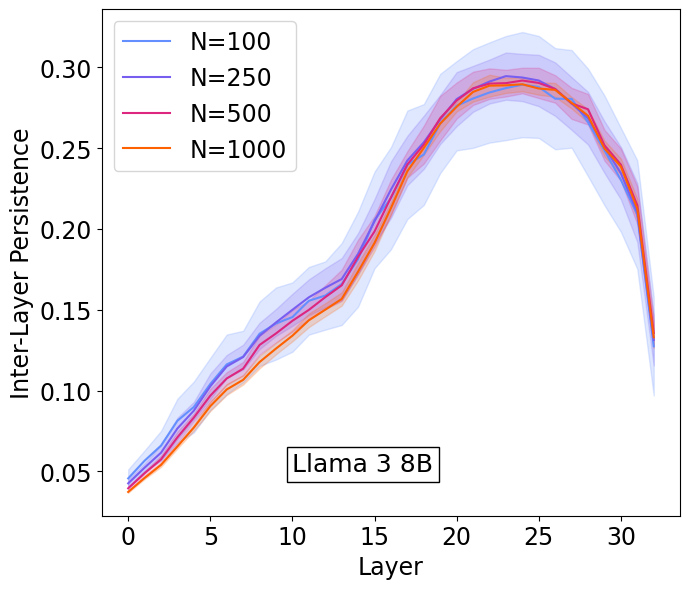

In [18]:
p=0
edf_100_llama3 = []
edf_250_llama3 = []
edf_500_llama3 = []
edf_1000_llama3 = []

for model in split_100_llama3b:
    edf_100_llama3.append(weighed_inter_layer_persistance(inter_layer_persistance(model, num_layers),num_layers,p))
for model in split_250_llama3b:
    edf_250_llama3.append(weighed_inter_layer_persistance(inter_layer_persistance(model, num_layers),num_layers,p))
for model in split_500_llama3b:
    edf_500_llama3.append(weighed_inter_layer_persistance(inter_layer_persistance(model, num_layers),num_layers,p))
for model in split_1000_llama3b:
    edf_1000_llama3.append(weighed_inter_layer_persistance(inter_layer_persistance(model, num_layers),num_layers,p))

edf_100_llama3_mean = np.mean(edf_100_llama3, axis=0)
edf_100_llama3_std = np.std(edf_100_llama3, axis=0)
edf_250_llama3_mean = np.mean(edf_250_llama3, axis=0)
edf_250_llama3_std = np.std(edf_250_llama3, axis=0)
edf_500_llama3_mean = np.mean(edf_500_llama3, axis=0)
edf_500_llama3_std = np.std(edf_500_llama3, axis=0)
edf_1000_llama3_mean = np.mean(edf_1000_llama3, axis=0)
edf_1000_llama3_std = np.std(edf_1000_llama3, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
x = np.arange(num_layers)
ax.plot(x, edf_100_llama3_mean, color=cb_palette[0], label='N=100')
ax.fill_between(x, edf_100_llama3_mean - edf_100_llama3_std, edf_100_llama3_mean + edf_100_llama3_std, color=cb_palette[0], alpha=0.2)
ax.plot(x, edf_250_llama3_mean, color=cb_palette[1], label='N=250')
ax.fill_between(x, edf_250_llama3_mean - edf_250_llama3_std, edf_250_llama3_mean + edf_250_llama3_std, color=cb_palette[1], alpha=0.2)
ax.plot(x, edf_500_llama3_mean, color=cb_palette[2], label='N=500')
ax.fill_between(x, edf_500_llama3_mean - edf_500_llama3_std, edf_500_llama3_mean + edf_500_llama3_std, color=cb_palette[2], alpha=0.2)
ax.plot(x, edf_1000_llama3_mean, color=cb_palette[3], label='N=1000')
ax.fill_between(x, edf_1000_llama3_mean - edf_1000_llama3_std, edf_1000_llama3_mean + edf_1000_llama3_std, color=cb_palette[3], alpha=0.2)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.text(10, 0.05, 'Llama 3 8B', fontsize=18, bbox=dict(facecolor='white'))
ax.set_xlabel('Layer', fontsize=17)
ax.set_ylabel('Inter-Layer Persistence', fontsize=17)
ax.legend(fontsize=17)
plt.tight_layout()
plt.show()

# Figure 11

In [19]:
p=0.1
avgsim_100_llama3_sst = []
avgsim_125_llama3_sst = []
avgsim_160_llama3_sst = []
avgsim_200_llama3_sst = []
avgsim_250_llama3_sst = []
avgsim_320_llama3_sst = []
avgsim_400_llama3_sst = []
avgsim_500_llama3_sst = []
avgsim_640_llama3_sst = []
avgsim_800_llama3_sst = []
avgsim_1000_llama3_sst = []

for model in split_100_llama3b:
    avgsim_100_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_125_llama3b:
    avgsim_125_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_160_llama3b:
    avgsim_160_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_200_llama3b:
    avgsim_200_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_250_llama3b:
    avgsim_250_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_320_llama3b:
    avgsim_320_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_400_llama3b:
    avgsim_400_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_500_llama3b:
    avgsim_500_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_640_llama3b:
    avgsim_640_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_800_llama3b:
    avgsim_800_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))
for model in split_1000_llama3b:
    avgsim_1000_llama3_sst.append(weighed_inter_layer_persistance(inter_layer_persistance(model,num_layers),num_layers,p))

avgsim_100_llama3_sst_mean = np.mean(avgsim_100_llama3_sst, axis=0)
avgsim_100_llama3_sst_std = np.std(avgsim_100_llama3_sst, axis=0)

avgsim_125_llama3_sst_mean = np.mean(avgsim_125_llama3_sst, axis=0)
avgsim_125_llama3_sst_std = np.std(avgsim_125_llama3_sst, axis=0)

avgsim_160_llama3_sst_mean = np.mean(avgsim_160_llama3_sst, axis=0)
avgsim_160_llama3_sst_std = np.std(avgsim_160_llama3_sst, axis=0)

avgsim_200_llama3_sst_mean = np.mean(avgsim_200_llama3_sst, axis=0)
avgsim_200_llama3_sst_std = np.std(avgsim_200_llama3_sst, axis=0)

avgsim_250_llama3_sst_mean = np.mean(avgsim_250_llama3_sst, axis=0)
avgsim_250_llama3_sst_std = np.std(avgsim_250_llama3_sst, axis=0)

avgsim_320_llama3_sst_mean = np.mean(avgsim_320_llama3_sst, axis=0)
avgsim_320_llama3_sst_std = np.std(avgsim_320_llama3_sst, axis=0)

avgsim_400_llama3_sst_mean = np.mean(avgsim_400_llama3_sst, axis=0)
avgsim_400_llama3_sst_std = np.std(avgsim_400_llama3_sst, axis=0)

avgsim_500_llama3_sst_mean = np.mean(avgsim_500_llama3_sst, axis=0)
avgsim_500_llama3_sst_std = np.std(avgsim_500_llama3_sst, axis=0)

avgsim_640_llama3_sst_mean = np.mean(avgsim_640_llama3_sst, axis=0)
avgsim_640_llama3_sst_std = np.std(avgsim_640_llama3_sst, axis=0)

avgsim_800_llama3_sst_mean = np.mean(avgsim_800_llama3_sst, axis=0)
avgsim_800_llama3_sst_std = np.std(avgsim_800_llama3_sst, axis=0)

avgsim_1000_llama3_sst_mean = np.mean(avgsim_1000_llama3_sst, axis=0)
avgsim_1000_llama3_sst_std = np.std(avgsim_1000_llama3_sst, axis=0)

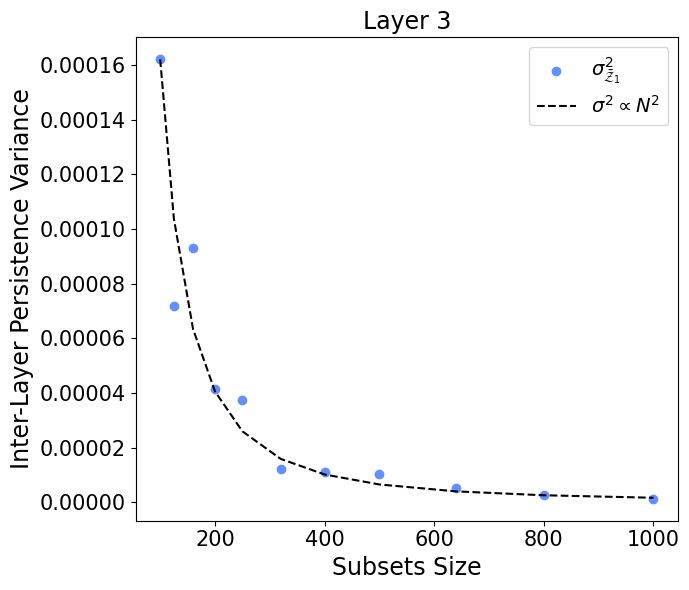

In [20]:
plt.figure(figsize=(7, 6))
x = [100,125,160,200,250,320,400,500,640,800,1000]
layer = 3
for i in [layer]:
        plt.scatter(100, avgsim_100_llama3_sst_std[i]**2, color=cb_palette[0], label='$\\sigma^2_{\\bar{\\mathcal{Z}}_1}$')
        plt.scatter(125, avgsim_125_llama3_sst_std[i]**2, color=cb_palette[0])
        plt.scatter(160, avgsim_160_llama3_sst_std[i]**2, color=cb_palette[0])
        plt.scatter(200, avgsim_200_llama3_sst_std[i]**2, color=cb_palette[0])
        plt.scatter(250, avgsim_250_llama3_sst_std[i]**2, color=cb_palette[0])
        plt.scatter(320, avgsim_320_llama3_sst_std[i]**2, color=cb_palette[0])
        plt.scatter(400, avgsim_400_llama3_sst_std[i]**2, color=cb_palette[0])
        plt.scatter(500, avgsim_500_llama3_sst_std[i]**2, color=cb_palette[0])
        plt.scatter(640, avgsim_640_llama3_sst_std[i]**2, color=cb_palette[0])
        plt.scatter(800, avgsim_800_llama3_sst_std[i]**2, color=cb_palette[0])
        plt.scatter(1000, avgsim_1000_llama3_sst_std[i]**2, color=cb_palette[0])
x1 = [avgsim_100_llama3_sst_std[layer]**2/(a/100)**(2) for a in x]
plt.plot(x, x1, color='k', label='$\\sigma^2 \\propto N^{2}$',ls='--')
plt.title('Layer '+str(layer),fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Subsets Size',fontsize=17)
plt.ylabel('Inter-Layer Persistence Variance', fontsize=17)
#plt.set_yscale('log')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


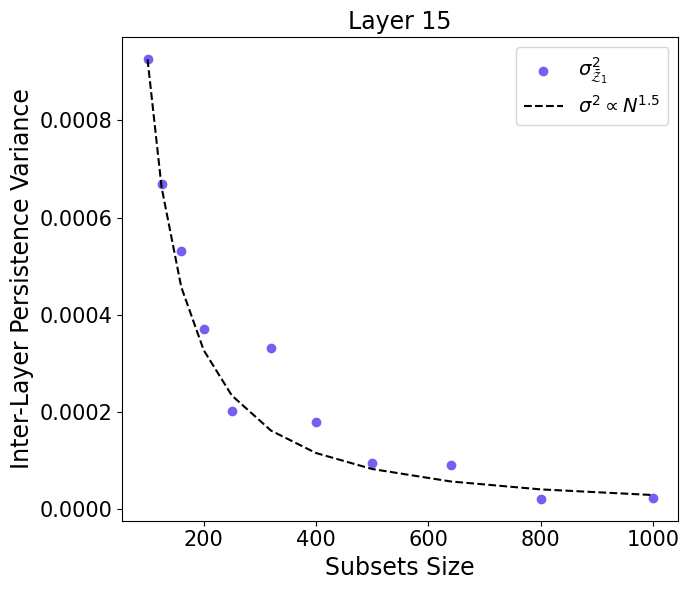

In [21]:
plt.figure(figsize=(7, 6))
x = [100,125,160,200,250,320,400,500,640,800,1000]
layer = 15
for i in [layer]:
        plt.scatter(100, avgsim_100_llama3_sst_std[i]**2, color=cb_palette[1], label='$\\sigma^2_{\\bar{\\mathcal{Z}}_1}$')
        plt.scatter(125, avgsim_125_llama3_sst_std[i]**2, color=cb_palette[1])
        plt.scatter(160, avgsim_160_llama3_sst_std[i]**2, color=cb_palette[1])
        plt.scatter(200, avgsim_200_llama3_sst_std[i]**2, color=cb_palette[1])
        plt.scatter(250, avgsim_250_llama3_sst_std[i]**2, color=cb_palette[1])
        plt.scatter(320, avgsim_320_llama3_sst_std[i]**2, color=cb_palette[1])
        plt.scatter(400, avgsim_400_llama3_sst_std[i]**2, color=cb_palette[1])
        plt.scatter(500, avgsim_500_llama3_sst_std[i]**2, color=cb_palette[1])
        plt.scatter(640, avgsim_640_llama3_sst_std[i]**2, color=cb_palette[1])
        plt.scatter(800, avgsim_800_llama3_sst_std[i]**2, color=cb_palette[1])
        plt.scatter(1000, avgsim_1000_llama3_sst_std[i]**2, color=cb_palette[1])
x1 = [avgsim_100_llama3_sst_std[layer]**(2)/(a/100)**(3/2) for a in x]
plt.plot(x, x1, color='k', label='$\\sigma^2 \\propto N^{1.5}$',ls='--')
plt.title('Layer '+str(layer),fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Subsets Size',fontsize=17)
plt.ylabel('Inter-Layer Persistence Variance', fontsize=17)
#plt.set_yscale('log')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

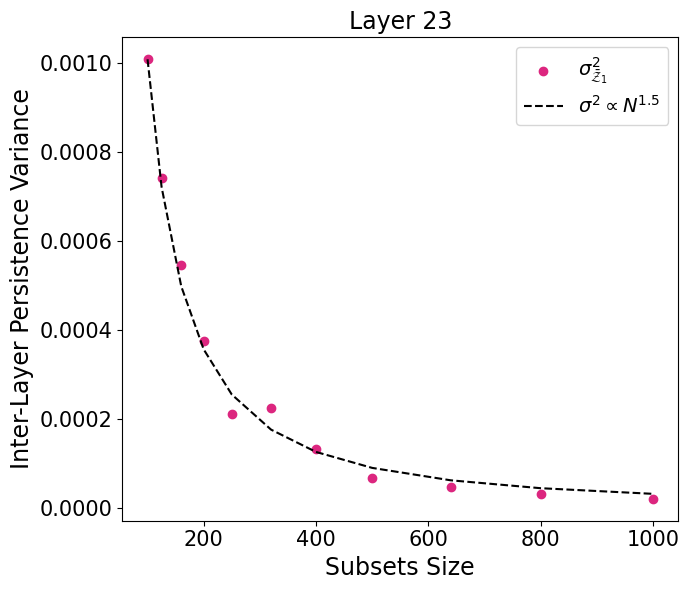

In [22]:
plt.figure(figsize=(7, 6))
x = [100,125,160,200,250,320,400,500,640,800,1000]
layer = 23
for i in [layer]:
        plt.scatter(100, avgsim_100_llama3_sst_std[i]**2, color=cb_palette[2], label='$\\sigma^2_{\\bar{\\mathcal{Z}}_1}$')
        plt.scatter(125, avgsim_125_llama3_sst_std[i]**2, color=cb_palette[2])
        plt.scatter(160, avgsim_160_llama3_sst_std[i]**2, color=cb_palette[2])
        plt.scatter(200, avgsim_200_llama3_sst_std[i]**2, color=cb_palette[2])
        plt.scatter(250, avgsim_250_llama3_sst_std[i]**2, color=cb_palette[2])
        plt.scatter(320, avgsim_320_llama3_sst_std[i]**2, color=cb_palette[2])
        plt.scatter(400, avgsim_400_llama3_sst_std[i]**2, color=cb_palette[2])
        plt.scatter(500, avgsim_500_llama3_sst_std[i]**2, color=cb_palette[2])
        plt.scatter(640, avgsim_640_llama3_sst_std[i]**2, color=cb_palette[2])
        plt.scatter(800, avgsim_800_llama3_sst_std[i]**2, color=cb_palette[2])
        plt.scatter(1000, avgsim_1000_llama3_sst_std[i]**2, color=cb_palette[2])
x1 = [avgsim_100_llama3_sst_std[layer]**(2)/(a/100)**(3/2) for a in x]
plt.plot(x, x1, color='k', label='$\\sigma^2 \\propto N^{1.5}$',ls='--')
plt.title('Layer '+str(layer),fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Subsets Size',fontsize=17)
plt.ylabel('Inter-Layer Persistence Variance', fontsize=17)
#plt.set_yscale('log')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

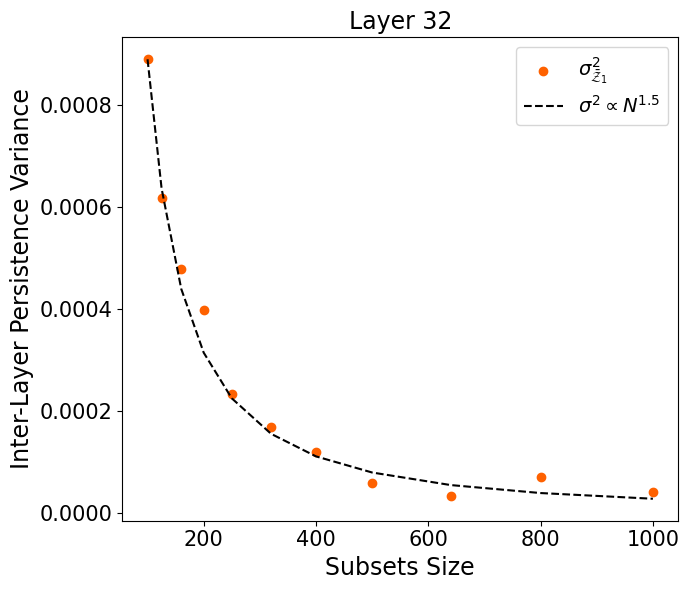

In [23]:
plt.figure(figsize=(7, 6))
x = [100,125,160,200,250,320,400,500,640,800,1000]
layer = 32
for i in [layer]:
        plt.scatter(100, avgsim_100_llama3_sst_std[i]**2, color=cb_palette[3], label='$\\sigma^2_{\\bar{\\mathcal{Z}}_1}$')
        plt.scatter(125, avgsim_125_llama3_sst_std[i]**2, color=cb_palette[3])
        plt.scatter(160, avgsim_160_llama3_sst_std[i]**2, color=cb_palette[3])
        plt.scatter(200, avgsim_200_llama3_sst_std[i]**2, color=cb_palette[3])
        plt.scatter(250, avgsim_250_llama3_sst_std[i]**2, color=cb_palette[3])
        plt.scatter(320, avgsim_320_llama3_sst_std[i]**2, color=cb_palette[3])
        plt.scatter(400, avgsim_400_llama3_sst_std[i]**2, color=cb_palette[3])
        plt.scatter(500, avgsim_500_llama3_sst_std[i]**2, color=cb_palette[3])
        plt.scatter(640, avgsim_640_llama3_sst_std[i]**2, color=cb_palette[3])
        plt.scatter(800, avgsim_800_llama3_sst_std[i]**2, color=cb_palette[3])
        plt.scatter(1000, avgsim_1000_llama3_sst_std[i]**2, color=cb_palette[3])
x1 = [avgsim_100_llama3_sst_std[layer]**(2)/(a/100)**(3/2) for a in x]
plt.plot(x, x1, color='k', label='$\\sigma^2 \\propto N^{1.5}$',ls='--')
plt.title('Layer '+str(layer),fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Subsets Size',fontsize=17)
plt.ylabel('Inter-Layer Persistence Variance', fontsize=17)
#plt.set_yscale('log')
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

# Figure 12

In [24]:
llama3_8b = './csv/sst/llama_3_8b_dim_4_knn_4_last_token.csv'
llama3_shuffled = './csv/sst/llama3_8_sst_shuffled_knn_5_dim_4.csv'

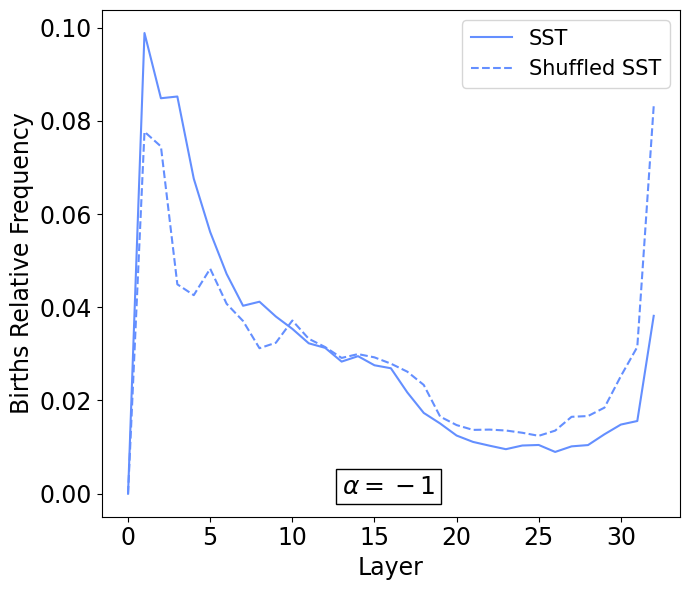

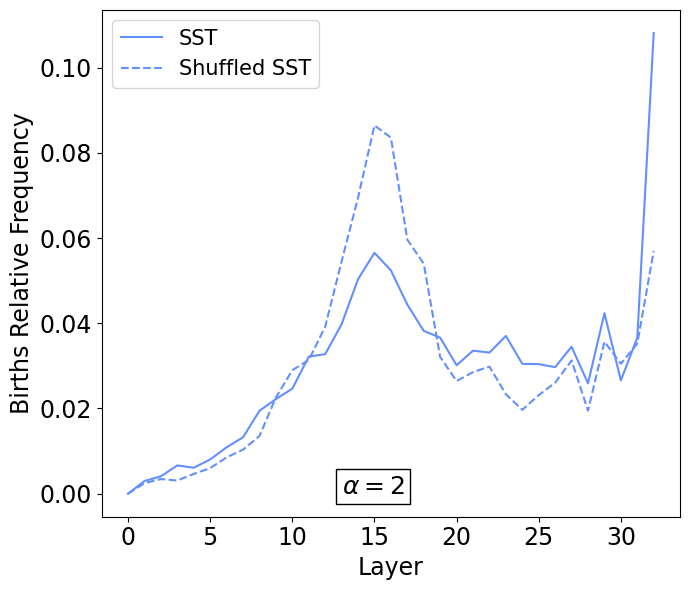

In [25]:
num_layers = 33

for p in [-1.,2]:
    avgsim_llama3 = []
    avgsim_llama3_shuffled = []

    avgsim_llama3 = pi_hist(llama3_8b,num_layers,p)
    #avgsim_llama3= weighed_inter_layer_persistance(inter_layer_persistance(llama3_8b, num_layers),num_layers,p)
    avgsim_llama3_shuffled = pi_hist(llama3_shuffled,num_layers,p)
    #avgsim_llama3_shuffled= weighed_inter_layer_persistance(inter_layer_persistance(llama3_shuffled, num_layers),num_layers,p)
    plt.figure(figsize=(7, 6))
    x = np.arange(num_layers)
    plt.plot(x, avgsim_llama3, color=cb_palette[0], label='SST')
    plt.plot(x, avgsim_llama3_shuffled, color=cb_palette[0], label='Shuffled SST',ls='--')
    plt.tick_params(axis='both', which='major', labelsize=17)
    plt.text(13, 0.0, '$\\alpha = %d$' % p, bbox=dict(facecolor='white', alpha=1.0), fontsize=18)
    plt.xlabel('Layer', fontsize=17)
    plt.ylabel('Births Relative Frequency', fontsize=17)
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()

# Figure 13

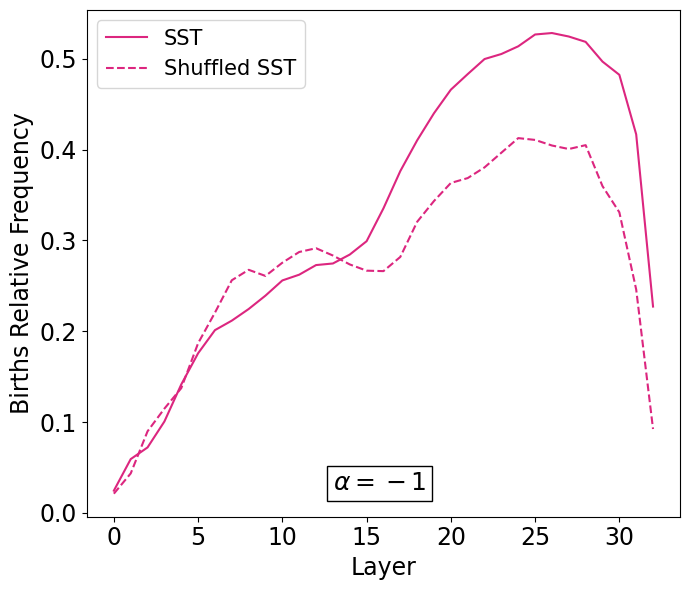

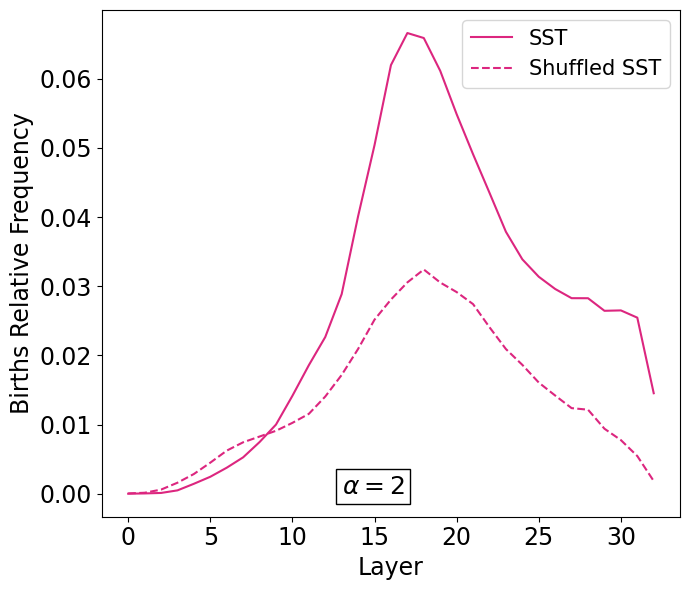

In [27]:
num_layers = 33
for p in [-1.,2]:
    avgsim_llama3 = []
    avgsim_llama3_shuffled = []
    avgsim_llama3= weighed_inter_layer_persistance(inter_layer_persistance(llama3_8b, num_layers),num_layers,p)
    avgsim_llama3_shuffled= weighed_inter_layer_persistance(inter_layer_persistance(llama3_shuffled, num_layers),num_layers,p)
    plt.figure(figsize=(7, 6))
    x = np.arange(num_layers)
    plt.plot(x, avgsim_llama3, color=cb_palette[2], label='SST')
    plt.plot(x, avgsim_llama3_shuffled, color=cb_palette[2], label='Shuffled SST',ls='--')
    plt.tick_params(axis='both', which='major', labelsize=17)
    if p == -1 :
        plt.text(13, 0.025, '$\\alpha = %d$' % p, bbox=dict(facecolor='white', alpha=1.0), fontsize=18)
    else:
        plt.text(13, 0.0, '$\\alpha = %d$' % p, bbox=dict(facecolor='white', alpha=1.0), fontsize=18)
    plt.xlabel('Layer', fontsize=17)
    plt.ylabel('Births Relative Frequency', fontsize=17)
    plt.legend(fontsize=15)
    plt.tight_layout()
    plt.show()